In [ ]:
%pip install -r requirementsBenchmark.txt

  Using cached pandas-2.3.1-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.3 MB 10.7 MB/s eta 0:00:01
   ------------- -------------------------- 3.9/11.3 MB 9.8 MB/s eta 0:00:01
   ---------------------- ----------------- 6.3/11.3 MB 10.2 MB/s eta 0:00:01
   ---------------------------- ----------- 8.1/11.3 MB 10.1 MB/s eta 0:00:01
   ----------------------------------- ---- 10.0/11.3 MB 9.7 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 9.1 MB/s eta 0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

   ---------------------------------------- 0/3 [pytz]
   ---------------------------------------- 0/3 [pytz]
   ---------------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# --------- Helpers ---------
def normalize_name(s: str) -> str:
    """
    Clef d'appariement robuste :
    - garde le nom de base (sans chemin)
    - enlève l'extension
    - supprime espaces
    - met en minuscules
    """
    if pd.isna(s):
        return ""
    base = os.path.basename(str(s)).strip()
    # supprime extension si présente
    name_no_ext = re.sub(r"\.[A-Za-z0-9]+$", "", base)
    return name_no_ext.strip().lower()

# --------- I/O ---------
def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    for col in ["index","filename","label","confidence","processing_time_sec","video_duration_sec","file_size_mb"]:
        if col not in df.columns:
            df[col] = np.nan
    return df

def load_meta(meta_path: str) -> pd.DataFrame:
    """
    Attend deux colonnes: file, label
    """
    m = pd.read_csv(meta_path)
    m.columns = [c.strip().lower() for c in m.columns]
    if not {"file","label"}.issubset(set(m.columns)):
        raise ValueError("Le méta CSV doit contenir les colonnes: file,label")
    m["label"] = m["label"].astype(str).str.upper().str.strip()
    m["name_key"] = m["file"].apply(normalize_name)
    # On garde uniquement les labels attendus
    ok_mask = m["label"].isin(["REAL","FAKE"])
    if (~ok_mask).any():
        print("⚠️  Lignes ignorées dans le méta (label non reconnu):")
        display(m.loc[~ok_mask, ["file","label"]])
    m = m[ok_mask].copy()
    return m[["name_key","label"]].rename(columns={"label":"true_label"})

# --------- Nettoyage & Merge méta ---------
def clean_df(df: pd.DataFrame, meta_df: pd.DataFrame | None = None) -> pd.DataFrame:
    d = df.copy()
    d["label"] = d["label"].astype(str).str.upper().str.strip()
    for col in ["confidence","processing_time_sec","video_duration_sec","file_size_mb"]:
        d[col] = pd.to_numeric(d[col], errors="coerce")

    # Clef d'appariement
    d["name_key"] = d["filename"].apply(normalize_name)

    # Vérité terrain depuis le méta si fourni, sinon REAL par défaut (comme avant)
    if meta_df is not None and not meta_df.empty:
        d = d.merge(meta_df, on="name_key", how="left")
        missing_meta = d["true_label"].isna().sum()
        if missing_meta > 0:
            print(f"⚠️  {missing_meta} fichier(s) du dataset n'ont pas d'entrée dans le méta. Ils seront marqués REAL par défaut.")
        d["true_label"] = d["true_label"].fillna("REAL")
    else:
        d["true_label"] = "REAL"

    # Prédictions binaires à partir de 'label' (sortie modèle)
    d["pred_is_real"] = d["label"].eq("REAL")
    d["pred_is_fake"] = d["label"].eq("FAKE")
    d["pred_label"] = np.where(d["pred_is_fake"], "FAKE",
                         np.where(d["pred_is_real"], "REAL", "UNKNOWN"))

    # Correct/erreur + type d'erreur standard
    d["is_correct"] = d["pred_label"].eq(d["true_label"])
    d["error_type"] = np.where(
        (d["true_label"].eq("REAL")) & (d["pred_label"].eq("FAKE")), "FP (REAL→FAKE)",
        np.where(
            (d["true_label"].eq("FAKE")) & (d["pred_label"].eq("REAL")), "FN (FAKE→REAL)",
            ""
        )
    )

    # Tri stable
    if "index" in d.columns:
        d = d.sort_values(by=["index","filename"], kind="stable", na_position='last')
    else:
        d = d.sort_values(by=["filename"], kind="stable")
    d.reset_index(drop=True, inplace=True)
    return d

# --------- Métriques ---------
def compute_metrics(d: pd.DataFrame):
    # Positif = FAKE ; Négatif = REAL
    tp = int(((d["true_label"] == "FAKE") & (d["pred_label"] == "FAKE")).sum())
    tn = int(((d["true_label"] == "REAL") & (d["pred_label"] == "REAL")).sum())
    fp = int(((d["true_label"] == "REAL") & (d["pred_label"] == "FAKE")).sum())
    fn = int(((d["true_label"] == "FAKE") & (d["pred_label"] == "REAL")).sum())

    total = tp + tn + fp + fn

    accuracy     = (tp + tn) / total if total > 0 else float("nan")
    recall       = tp / (tp + fn) if (tp + fn) > 0 else float("nan")            # TPR pour FAKE
    precision    = tp / (tp + fp) if (tp + fp) > 0 else float("nan")            # PPV pour FAKE

    return {
        "TP ": tp,
        "FP ": fp,
        "TN ": tn,
        "FN ": fn,
        "total_samples": total,
        "accuracy": accuracy,
        "recall_FAKE_sensitivity": recall,
        "precision_FAKE": precision,
    }

# ====== Usage ======
# 1) Chemins (à adapter)
CSV_PATH = "benchmark_results.csv"
META_CSV_PATH = "global_meta_fake.csv"

# 2) Chargement
df_raw   = load_csv(CSV_PATH)
meta_map = load_meta(META_CSV_PATH)

# 3) Nettoyage + appariement méta
df = clean_df(df_raw, meta_map)

# 4) Métriques
metrics = compute_metrics(df)
print("=== Metrics (positive class = FAKE, negative class = REAL) ===")
for k, v in metrics.items():
    print(f"{k}: {v}")

# 5) Affichage
display(HTML("<h3>Tableau complet</h3>"))
display(df[[
   "index","filename","true_label","pred_label","label",
    "confidence","processing_time_sec","video_duration_sec","file_size_mb",
    "is_correct","error_type"
]])


=== Metrics (positive class = FAKE, negative class = REAL) ===
TP : 7
FP : 0
TN : 0
FN : 15
total_samples: 22
accuracy: 0.3181818181818182
recall_FAKE_sensitivity: 0.3181818181818182
precision_FAKE: 1.0


,index,filename,true_label,pred_label,label,confidence,processing_time_sec,video_duration_sec,file_size_mb,is_correct,error_type
0,29,VIDEO_29_HD_SHORT.mp4,FAKE,FAKE,FAKE,52.17,0.96,10.000000,0.516,True,
1,30,VIDEO_30_HD_SHORT.mp4,FAKE,REAL,REAL,55.74,0.63,9.511706,0.456,False,FN (FAKE→REAL)
2,31,VIDEO_31_HD_SHORT.mp4,FAKE,FAKE,FAKE,54.13,0.57,10.600000,0.517,True,
3,32,VIDEO_32_HD_SHORT.mp4,FAKE,REAL,REAL,55.94,0.71,10.833333,1.051,False,FN (FAKE→REAL)
4,33,VIDEO_33_HD_SHORT.mp4,FAKE,REAL,REAL,60.69,0.70,10.466667,0.917,False,FN (FAKE→REAL)
5,34,VIDEO_34_HD_SHORT.mp4,FAKE,REAL,REAL,57.11,0.74,11.000000,1.162,False,FN (FAKE→REAL)
6,35,VIDEO_35_HD_SHORT.mp4,FAKE,REAL,REAL,60.45,0.83,5.041667,0.491,False,FN (FAKE→REAL)
7,36,VIDEO_36_HD_SHORT.mp4,FAKE,REAL,REAL,56.65,0.67,5.041667,0.642,False,FN (FAKE→REAL)
8,37,VIDEO_37_HD_SHORT.mp4,FAKE,FAKE,FAKE,54.32,0.68,5.125000,0.582,True,
9,38,VIDEO_38_HD_SHORT.mp4,FAKE,REAL,REAL,56.08,0.68,5.125000,0.620,False,FN (FAKE→REAL)


In [2]:
import requests
import pandas as pd
import time
from pathlib import Path
import re
import mimetypes
import matplotlib.pyplot as plt
import numpy as np  # <-- added

# ===== CONFIG =====
API_URL = "http://127.0.0.1:8000/predict/"  # your FastAPI endpoint
VIDEO_DIR = Path("./videos")                 # adjust if needed
FACE_ALGOS = ["mediapipe", "haar"]
TIMEOUT_SEC = 120

# Accepted video extensions (add more if you need)
VIDEO_EXTS = {".mp4", ".mov", ".avi", ".mkv", ".webm", ".flv", ".wmv", ".mpeg", ".mpg"}

# ===== Helpers =====
def parse_video_name(filename_stem: str):
    """
    Supported examples:
      VIDEO_7_HD_SHORT.mp4
      VIDEO_1_HD_LONG.MOV
      VIDEO_1_SD_LONGUE.mp4
    Returns: (video_id, quality, duration_category)
    """
    m = re.match(r"^(.*)_(HD|SD)_(SHORT|LONG|COURTE|LONGUE?)$", filename_stem, re.IGNORECASE)
    if not m:
        return filename_stem, "UNKNOWN", "UNKNOWN"

    video_id = m.group(1)
    quality = m.group(2).upper()
    duration_raw = m.group(3).upper()

    if duration_raw in {"SHORT", "COURTE"}:
        duration_category = "SHORT"
    elif duration_raw in {"LONG", "LONGUE"}:
        duration_category = "LONG"
    else:
        duration_category = "UNKNOWN"

    return video_id, quality, duration_category

def guess_mime(path: Path) -> str:
    # Ensure correct content-type (e.g., .mov -> video/quicktime)
    ctype, _ = mimetypes.guess_type(path.name)
    return ctype or "application/octet-stream"

def to_float(x):
    try:
        return float(x)
    except Exception:
        return None

# ===== Collect =====
results = []
errors = []

if not VIDEO_DIR.exists():
    raise SystemExit(f"Video directory not found: {VIDEO_DIR.resolve()}")

for video_path in VIDEO_DIR.glob("*"):
    if video_path.suffix.lower() not in VIDEO_EXTS:
        continue

    video_id, quality, duration_cat = parse_video_name(video_path.stem)

    for algo in FACE_ALGOS:
        print(f"[TEST] {video_path.name} | algo={algo} | quality={quality} | duration={duration_cat}")
        try:
            with open(video_path, "rb") as f:
                t0 = time.time()
                resp = requests.post(
                    f"{API_URL}?face_algo={algo}",
                    files={"file": (video_path.name, f, guess_mime(video_path))},
                    timeout=TIMEOUT_SEC,
                )
                t1 = time.time()
        except Exception as e:
            errors.append({"video_name": video_path.name, "face_algo": algo, "error": f"exception: {e}"})
            continue

        if resp.status_code != 200:
            errors.append({
                "video_name": video_path.name,
                "face_algo": algo,
                "error": f"status {resp.status_code}",
                "response_text": resp.text[:500],
            })
            continue

        try:
            data = resp.json()
        except Exception as e:
            errors.append({"video_name": video_path.name, "face_algo": algo, "error": f"json decode: {e}"})
            continue

        meta = data.get("metadata", {}) or {}
        processing_time = to_float(data.get("processing_time_sec", t1 - t0))

        results.append({
            "video_id": video_id,
            "video_name": data.get("filename", video_path.name),
            "quality": quality,
            "duration_category": duration_cat,
            "face_algo": algo,

            "processing_time_sec": processing_time,
            "duration_video_sec": to_float(meta.get("duration")),
            "resolution": f"{meta.get('width', '?')}x{meta.get('height', '?')}",
            "codec": meta.get("video_codec", "?"),
            "frame_rate": meta.get("frame_rate"),
            "nb_frames": meta.get("nb_frames"),
            "bit_rate": meta.get("bit_rate"),
            "result_label": data.get("result"),
            "result_confidence": to_float(data.get("confidence")),
            "analyzed_at": data.get("analyzed_at"),
        })

# Fixed columns to avoid KeyError if results is empty
cols = [
    "video_id","video_name","quality","duration_category","face_algo",
    "processing_time_sec","duration_video_sec","resolution","codec",
    "frame_rate","nb_frames","bit_rate","result_label","result_confidence","analyzed_at"
]
df = pd.DataFrame(results, columns=cols)

# ---- Derive resolution-based buckets (distinguish <720p vs 720p vs 1080p) ----
wh = df["resolution"].astype(str).str.extract(r"(?P<w>\d+)\s*x\s*(?P<h>\d+)", expand=True)
df["width"]  = pd.to_numeric(wh["w"], errors="coerce")
df["height"] = pd.to_numeric(wh["h"], errors="coerce")
long_side = np.nanmax(df[["width", "height"]].values, axis=1)

def bucket_from_long_side(px):
    if pd.isna(px):
        return None
    if px >= 1080:
        return "HD_1080p"
    elif px >= 720:
        return "HD_720p"
    else:
        return "SD_<720p"

df["quality_bucket"] = pd.Series(long_side).apply(bucket_from_long_side)

# Optional: also infer coarse quality and detect mismatches
df["quality"] = df["quality"].astype(str).str.upper()
df["quality_inferred"] = np.where(long_side >= 720, "HD", "SD")
mismatches = df[df["quality"] != df["quality_inferred"]]
if not mismatches.empty:
    print("⚠️ Label vs inferred quality mismatches detected:")
    try:
        display(mismatches[["video_name", "quality", "resolution", "quality_inferred"]])
    except NameError:
        print(mismatches[["video_name", "quality", "resolution", "quality_inferred"]])

# Save with new columns
df.to_csv("benchmark_results_hd_sd.csv", index=False)
print("✅ Saved: benchmark_results_hd_sd.csv")

if errors:
    pd.DataFrame(errors).to_csv("benchmark_errors.csv", index=False)
    print(f"⚠️ Saved errors: benchmark_errors.csv ({len(errors)} rows)")

# Show a quick preview in non-notebook environments
try:
    display(df)
except NameError:
    print(df.head())

# ===== Plots =====
if not df.empty:
    # Common settings
    algos = ["mediapipe", "haar"]
    colors = {"mediapipe": "tab:blue", "haar": "tab:orange"}
    # Order buckets; only keep those present
    bucket_order = ["SD_<720p", "HD_720p", "HD_1080p"]

    # ---------- (1) SHORT only: grouped by resolution bucket, bars touching (Mediapipe vs Haar) ----------
    df_short = df[df["duration_category"].astype(str).str.upper() == "SHORT"].copy()
    present_buckets_short = [b for b in bucket_order if b in df_short["quality_bucket"].dropna().unique().tolist()]
    if present_buckets_short:
        means_short = {}
        for b in present_buckets_short:
            for a in algos:
                mask = (df_short["quality_bucket"] == b) & (df_short["face_algo"].astype(str).str.lower() == a)
                val = df_short.loc[mask, "processing_time_sec"].mean()
                means_short[(b, a)] = float(val) if pd.notna(val) else None

        x = np.arange(len(present_buckets_short))
        width = 0.22  # thinner bars, touching inside each group

        plt.figure(figsize=(max(10, 2.5 * len(present_buckets_short)), 5))
        for i, a in enumerate(algos):
            offset = -width/2 if i == 0 else width/2
            xpos, yvals = [], []
            for j, b in enumerate(present_buckets_short):
                m = means_short.get((b, a))
                if m is not None:
                    xpos.append(x[j] + offset)
                    yvals.append(m)
            if xpos:
                plt.bar(xpos, yvals, width=width, label=a.capitalize(), color=colors[a])

        plt.xticks(x, present_buckets_short)
        plt.xlabel("Resolution bucket")
        plt.ylabel("Average processing time (s)")
        plt.title("SHORT videos — Mediapipe vs Haar (grouped by resolution bucket)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No SHORT data found for plotting.")

    # ---------- (2) LONG only: grouped by resolution bucket, thinner bars ----------
    df_long = df[df["duration_category"].astype(str).str.upper() == "LONG"].copy()
    present_buckets_long = [b for b in bucket_order if b in df_long["quality_bucket"].dropna().unique().tolist()]
    if present_buckets_long:
        means_long = {}
        for b in present_buckets_long:
            for a in algos:
                mask = (df_long["quality_bucket"] == b) & (df_long["face_algo"].astype(str).str.lower() == a)
                val = df_long.loc[mask, "processing_time_sec"].mean()
                means_long[(b, a)] = float(val) if pd.notna(val) else None

        x = np.arange(len(present_buckets_long))
        width = 0.22

        plt.figure(figsize=(max(10, 2.5 * len(present_buckets_long)), 5))
        for i, a in enumerate(algos):
            offset = -width/2 if i == 0 else width/2
            xpos, yvals = [], []
            for j, b in enumerate(present_buckets_long):
                m = means_long.get((b, a))
                if m is not None:
                    xpos.append(x[j] + offset)
                    yvals.append(m)
            if xpos:
                plt.bar(xpos, yvals, width=width, label=a.capitalize(), color=colors[a])

        plt.xticks(x, present_buckets_long)
        plt.xlabel("Resolution bucket")
        plt.ylabel("Average processing time (s)")
        plt.title("LONG videos — Mediapipe vs Haar (grouped by resolution bucket)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No LONG data found for plotting.")
else:
    print("No results: check the VIDEO_DIR path and that the API returns HTTP 200.")


✅ Saved: benchmark_results_hd_sd.csv


,video_id,video_name,quality,duration_category,face_algo,processing_time_sec,duration_video_sec,resolution,codec,frame_rate,nb_frames,bit_rate,result_label,result_confidence,analyzed_at,width,height,quality_bucket,quality_inferred


No results: check the VIDEO_DIR path and that the API returns HTTP 200.


In [3]:
# Part 1 — Pairwise per-video comparison (bar pairs Mediapipe vs Haar), by resolution bucket, for a chosen duration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

CSV_PATH = "benchmark_results_hd_sd.csv"
DURATION_FILTER = "SHORT"   # change to "LONG" to compare long videos

# Ensure df is available
try:
    _ = df  # noqa
except NameError:
    df = pd.read_csv(CSV_PATH)

# Normalize basics
df["duration_category"] = df["duration_category"].astype(str).str.upper()
df["face_algo"] = df["face_algo"].astype(str).str.lower()

# Ensure quality_bucket exists (derive from resolution if missing)
if "quality_bucket" not in df.columns:
    wh = df["resolution"].astype(str).str.extract(r"(?P<w>\d+)\s*x\s*(?P<h>\d+)", expand=True)
    df["width"]  = pd.to_numeric(wh["w"], errors="coerce")
    df["height"] = pd.to_numeric(wh["h"], errors="coerce")
    long_side = np.nanmax(df[["width", "height"]].values, axis=1)

    def bucket_from_long_side(px):
        if pd.isna(px):
            return None
        if px >= 1080:
            return "HD_1080p"
        elif px >= 720:
            return "HD_720p"
        else:
            return "SD_<720p"

    df["quality_bucket"] = pd.Series(long_side).apply(bucket_from_long_side)

bucket_order = ["SD_<720p", "HD_720p", "HD_1080p"]
algos = ["mediapipe", "haar"]

sub_all = df[df["duration_category"] == DURATION_FILTER].copy()
present_buckets = [b for b in bucket_order if b in sub_all["quality_bucket"].dropna().unique().tolist()]

if not present_buckets:
    print(f"[Part 1] No data for duration={DURATION_FILTER}")
else:
    for b in present_buckets:
        sub = sub_all[sub_all["quality_bucket"] == b].copy()
        if sub.empty:
            continue

        # Aggregate in case multiple runs per (video_id, algo)
        pivot = (
            sub.groupby(["video_id", "face_algo"])["processing_time_sec"]
               .mean()
               .unstack("face_algo")
               .reindex(columns=algos)
        )

        # Keep only rows where we have both algos
        pivot = pivot.dropna(subset=algos, how="any")
        if pivot.empty:
            print(f"[Part 1] Not enough paired data for bucket={b}, duration={DURATION_FILTER}")
            continue

        x = np.arange(len(pivot.index))
        width = 0.36  # paired bars, slightly thinner

        plt.figure(figsize=(max(8, len(pivot) * 0.5), 5))
        plt.bar(x - width/2, pivot["mediapipe"].values, width=width, label="Mediapipe")
        plt.bar(x + width/2, pivot["haar"].values,      width=width, label="Haar")

        plt.xticks(x, pivot.index, rotation=45, ha="right")
        plt.xlabel("Video ID")
        plt.ylabel("Average processing time (s)")
        plt.title(f"{DURATION_FILTER} videos — Pairwise by video (Bucket: {b})")
        plt.legend()
        plt.tight_layout()
        plt.show()


[Part 1] No data for duration=SHORT


In [4]:
# Part 2 — Histograms of processing times per algorithm, separate plots for SHORT and LONG
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "benchmark_results_hd_sd.csv"

# Ensure df is available
try:
    _ = df  # noqa
except NameError:
    df = pd.read_csv(CSV_PATH)

# Normalize
df["duration_category"] = df["duration_category"].astype(str).str.upper()
df["face_algo"] = df["face_algo"].astype(str).str.lower()

def plot_hist_for_duration(duration_label: str):
    sub = df[df["duration_category"] == duration_label]
    if sub.empty:
        print(f"[Part 2] No data for duration={duration_label}")
        return

    mp = sub[sub["face_algo"] == "mediapipe"]["processing_time_sec"].dropna()
    hr = sub[sub["face_algo"] == "haar"]["processing_time_sec"].dropna()

    if mp.empty and hr.empty:
        print(f"[Part 2] No processing_time_sec for duration={duration_label}")
        return

    plt.figure(figsize=(10, 5))
    # Two overlaid histograms with transparency
    if not mp.empty:
        plt.hist(mp, bins=20, alpha=0.6, label="Mediapipe")
    if not hr.empty:
        plt.hist(hr, bins=20, alpha=0.6, label="Haar")

    plt.xlabel("Processing time (s)")
    plt.ylabel("Count")
    plt.title(f"Histogram of processing times — {duration_label} videos")
    plt.legend()
    plt.tight_layout()
    plt.show()

# SHORT histogram
plot_hist_for_duration("SHORT")
# LONG histogram
plot_hist_for_duration("LONG")


[Part 2] No data for duration=SHORT
[Part 2] No data for duration=LONG


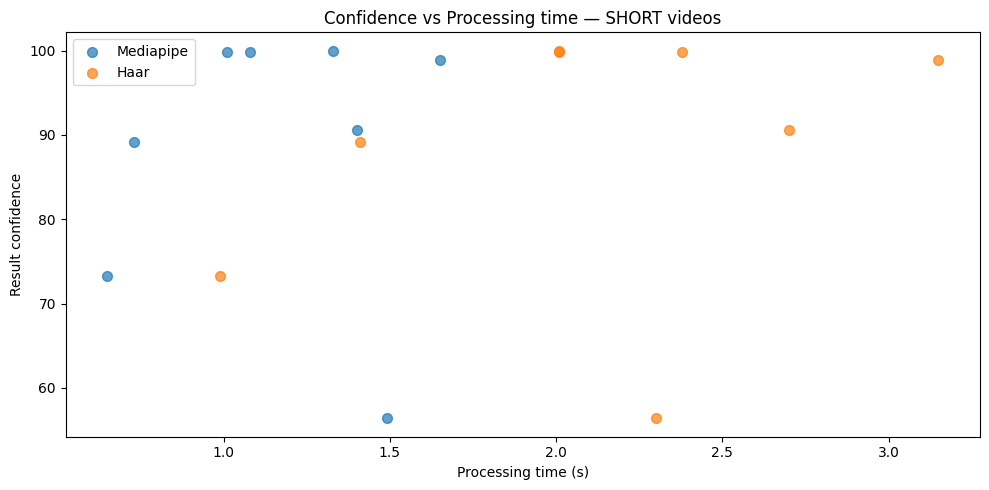

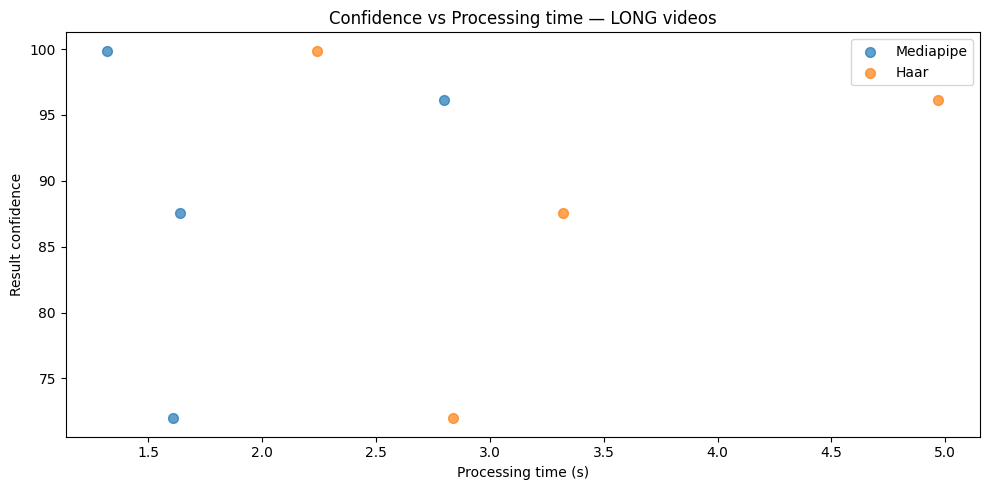

In [34]:
# Part 8 — Confidence vs Processing time (scatter), colored by algorithm, separate plots for SHORT and LONG
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "benchmark_results_hd_sd.csv"

# Ensure df is available
try:
    _ = df  # noqa
except NameError:
    df = pd.read_csv(CSV_PATH)

# Normalize
df["duration_category"] = df["duration_category"].astype(str).str.upper()
df["face_algo"] = df["face_algo"].astype(str).str.lower()

def scatter_confidence_vs_time(duration_label: str):
    sub = df[df["duration_category"] == duration_label].copy()
    sub = sub.dropna(subset=["processing_time_sec", "result_confidence"])
    if sub.empty:
        print(f"[Part 8] No data with confidence/time for duration={duration_label}")
        return

    plt.figure(figsize=(10, 5))
    for algo in ["mediapipe", "haar"]:
        s = sub[sub["face_algo"] == algo]
        if s.empty:
            continue
        plt.scatter(s["processing_time_sec"], s["result_confidence"], s=50, alpha=0.7, label=algo.capitalize())

    plt.xlabel("Processing time (s)")
    plt.ylabel("Result confidence")
    plt.title(f"Confidence vs Processing time — {duration_label} videos")
    plt.legend()
    plt.tight_layout()
    plt.show()

# SHORT scatter
scatter_confidence_vs_time("SHORT")
# LONG scatter
scatter_confidence_vs_time("LONG")
